### Exercise

In this exercise, we examine the VC generalization bound for the hypothesis class of linear classifiers. The bound is given by:
$$
R(f) \leq R_n(f) + \sqrt{\frac{8}{n}\left(d\cdot\ln\left(\frac{2en}{d}\right)+\ln\left(\frac{4}{\delta}\right)\right)} = R_n(f) + \varepsilon.
$$
Refer to page 19 of `vl06` for more details. The square root term on the right-hand side is referred to as the **error bound** $\varepsilon$.


**(a)**
Construct a binary classification problem with a large ground truth dataset to determine the true risk of a linear classifier and to sample training sets of varying sizes $n$.

**(b)**
Specify a sequence of training set sizes $n_1 < n_2 < \cdots < n_k$. For each training set size $n$:
- Calculate the error bound $\varepsilon$ for $\delta = 0.05$. 
- Conduct the following experiment $T$ times for each $n$:
  1. Draw a training set of size $n$.
  2. Fit a logistic regression model to the training data.
  3. Determine the empirical and true risk of the learned model.

**(c)**
Plot the average true risk, empirical risk, and the VC generalization bound as a function of the training set size $n$. 

**(d)**
Let $\varepsilon = \delta = 0.05$. Compute the theoretical sample complexity to ensure $R(f) \leq R_n(f) + \varepsilon$ with confidence $1-\delta$. 

**(e)**
Plot the estimated probability $\mathbb{P}(R(f) \leq R_n(f) + \varepsilon)$ as a function of $n$. Determine the empirical sample complexity to ensure $R(f) \leq R_n(f) + \varepsilon$ with confidence $1-\delta$. Compare the theoretical and empirical sample complexity.

---
### Imports

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

---
### Functions

In [3]:
# Returns random training set of size n
def sample(n):
    X_tr,_,y_tr,_ = train_test_split(X, y, train_size=n, stratify=y)
    return X_tr, y_tr

# Returns error bound eps
def error_bound(vcdim, n, delta):
    eps = vcdim * np.log(2 * np.e * n / vcdim)
    eps += np.log(4 / delta)
    eps *= 8 / n 
    return eps

# Returns size n of training examples required to ensure 
# 
#   R(f) <= Rn(f) + eps
# 
# with confidence 1−delta. The size n is computed by iterative approximation 
# with initial value n0. 
def sample_size(n0, vcdim, eps, delta):
    precision = 0.1
    n = n0
    n_previous = 0
    a = 8/eps**2 
    b = np.log(4/delta)
    while precision < abs(n - n_previous):
        n_previous = n
        n = a * (b + vcdim * np.log(2*np.e*n/vcdim))
    return np.ceil(n)


# Runs experiment. Returns
#   Rn  empirical risk
#   R   true risk
#   E   error bound
#   P   estimates of P(R(f) <= Rn(f) + E)
def run(n_samples, n_trials, eps):
    k = len(n_samples)
    Rn = np.zeros((k, n_trials))    # empirical risk
    R = np.zeros((k, n_trials))     # true risk
    E = np.zeros(k)                 # error bound
    
    clf = LogisticRegression()
    for i, n in enumerate(n_samples):
        E[i] = error_bound(VCDIM, n, DELTA)
        for j in range(n_trials):
            X_train, y_train = sample(n)
            clf = clf.fit(X_train, y_train)
            Rn[i,j] = 1.-clf.score(X_train, y_train)
            R[i,j] = 1.-clf.score(X, y)
    P = (R < Rn + eps).mean(axis=1) # P(R(f) < Rn(f) + eps)
    return Rn, R, E, P

---
### Ground Truth Data

In [2]:
N = int(1E6)
MU = np.array([[0, 0], [1, 1]])
X, y = make_blobs(n_samples=N, centers=MU,cluster_std=0.5)

---
### Experiment

In [4]:
VCDIM = 3
DELTA = 0.05
EPS = 0.05
N_TRIALS = 100
N_SAMPLES = np.arange(10, 101, 10)

##### Empirical Results

In [6]:
Rn, R, E, P = run(N_SAMPLES, N_TRIALS, EPS)

##### VC Generalization Bound

We show the average generalization bound, empirical mean, and true mean as a function of the size $n$ of the training set. The three quantities are averaged over N_TRIALS runs.

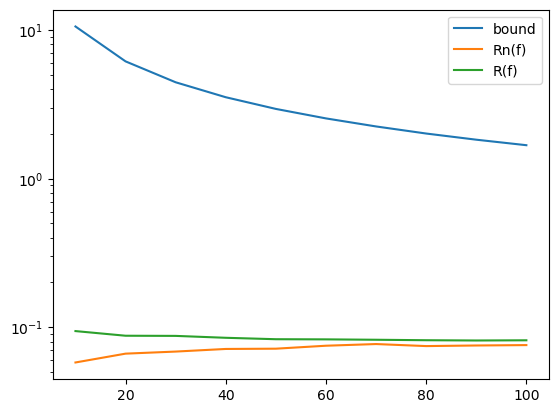

In [9]:
plt.semilogy(N_SAMPLES, E + Rn.mean(axis=1), label='bound')
plt.semilogy(N_SAMPLES, Rn.mean(axis=1), label='Rn(f)')
plt.semilogy(N_SAMPLES, R.mean(axis=1), label='R(f)')
plt.legend()
plt.show()


##### Theoretical Sample Complexity

We approximate the smallest $n$ to ensure 

$$
R(f) \leq R_n(f) + \varepsilon
$$

with confidence $1-\delta$ for a hypothesis class $\mathcal{H}$ with $\dim_{VC}(\mathcal{H})=$ VCDIM. 

In [5]:
n_tsc = sample_size(1000, VCDIM, EPS, DELTA)
print("n >= ", n_tsc)

n >=  132992.0


##### Empirical Sample Complexity

We determine the minimum size $n$ for which the estimated probability satisfies

$$
\mathbb{P}(R(f) \leq R_n(f) + \varepsilon) \geq 1-\delta
$$

In [7]:
i0 = np.argmax(P >= 1-DELTA)
n_esc = N_SAMPLES[i0]
print(f'n >= {n_esc:d}')

n >= 90


Observe that the theoretical sample complexity is $n_{tsc} = 132992$, while the empirical sample complexity is $n_{esc} \approx 90$. 


##### Estimated Probabilities
The next plot shows the estimated probability 

$$
\mathbb{P}(R(f) \leq R_n(f) + \varepsilon) 
$$

as a function of the size $n$ of the training set.

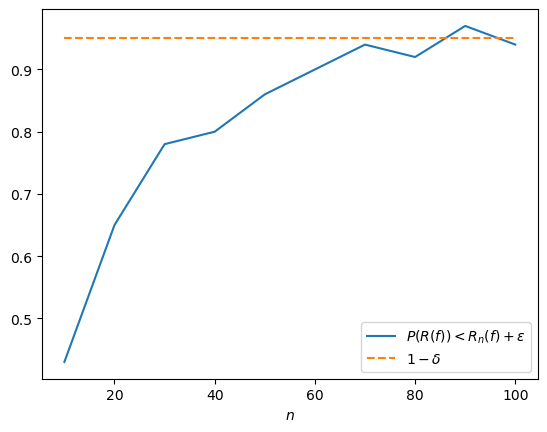

In [8]:
plt.plot(N_SAMPLES, P, label='$P(R(f)) < R_n(f) + \epsilon$')
c = np.ones_like(N_SAMPLES)-DELTA
plt.plot(N_SAMPLES, c, '--', label='$1-\delta$')
plt.xlabel('$n$')
plt.legend()
plt.show()